In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot

import dsets_classification
import model_classification


In [2]:
ds = dsets_classification.MalignantLunaDataset(val_stride=10, isValSet_bool=True)  # <1>
nodules = ds.ben_list + ds.mal_list
is_mal = torch.tensor([n.isMal_bool for n in nodules])  # <2>
diam  = torch.tensor([n.diameter_mm for n in nodules])
num_mal = is_mal.sum()  # <3>
num_ben = len(is_mal) - num_mal

2022-07-25 02:02:34,079 INFO     pid:30537 dsets_classification:295:__init__ <dsets_classification.MalignantLunaDataset object at 0x7f00732189d0>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio


In [5]:
threshold = torch.linspace(diam.max(), diam.min(), steps=89)

In [6]:
predictions = (diam[None] >= threshold[:, None])  # <1>
tp_diam = (predictions & is_mal[None]).sum(1).float() / num_mal  # <2>
fp_diam = (predictions & ~is_mal[None]).sum(1).float() / num_ben

In [7]:
fp_diam_diff =  fp_diam[1:] - fp_diam[:-1]
tp_diam_avg  = (tp_diam[1:] + tp_diam[:-1])/2
auc_diam = (fp_diam_diff * tp_diam_avg).sum()

In [8]:
fp_fill = torch.ones((fp_diam.shape[0] + 1,))
fp_fill[:-1] = fp_diam

tp_fill = torch.zeros((tp_diam.shape[0] + 1,))
tp_fill[:-1] = tp_diam

print(threshold)
print(fp_diam)
print(tp_diam)

tensor([22.7815, 22.5596, 22.3377, 22.1158, 21.8939, 21.6720, 21.4501, 21.2282,
        21.0062, 20.7843, 20.5624, 20.3405, 20.1186, 19.8967, 19.6748, 19.4529,
        19.2310, 19.0091, 18.7871, 18.5652, 18.3433, 18.1214, 17.8995, 17.6776,
        17.4557, 17.2338, 17.0119, 16.7900, 16.5680, 16.3461, 16.1242, 15.9023,
        15.6804, 15.4585, 15.2366, 15.0147, 14.7928, 14.5709, 14.3489, 14.1270,
        13.9051, 13.6832, 13.4613, 13.2394, 13.0175, 12.7956, 12.5737, 12.3518,
        12.1298, 11.9079, 11.6860, 11.4641, 11.2422, 11.0203, 10.7984, 10.5765,
        10.3546, 10.1327,  9.9107,  9.6888,  9.4669,  9.2450,  9.0231,  8.8012,
         8.5793,  8.3574,  8.1355,  7.9136,  7.6916,  7.4697,  7.2478,  7.0259,
         6.8040,  6.5821,  6.3602,  6.1383,  5.9164,  5.6945,  5.4725,  5.2506,
         5.0287,  4.8068,  4.5849,  4.3630,  4.1411,  3.9192,  3.6973,  3.4754,
         3.2534])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000

In [9]:
for i in range(threshold.shape[0]):
    print(i, threshold[i], fp_diam[i], tp_diam[i])

0 tensor(22.7815) tensor(0.) tensor(0.0192)
1 tensor(22.5596) tensor(0.) tensor(0.0192)
2 tensor(22.3377) tensor(0.) tensor(0.0192)
3 tensor(22.1158) tensor(0.) tensor(0.0192)
4 tensor(21.8939) tensor(0.) tensor(0.0192)
5 tensor(21.6720) tensor(0.) tensor(0.0192)
6 tensor(21.4501) tensor(0.) tensor(0.0192)
7 tensor(21.2282) tensor(0.) tensor(0.0192)
8 tensor(21.0062) tensor(0.) tensor(0.0385)
9 tensor(20.7843) tensor(0.) tensor(0.0385)
10 tensor(20.5624) tensor(0.) tensor(0.0385)
11 tensor(20.3405) tensor(0.) tensor(0.0385)
12 tensor(20.1186) tensor(0.) tensor(0.0385)
13 tensor(19.8967) tensor(0.) tensor(0.0385)
14 tensor(19.6748) tensor(0.) tensor(0.0385)
15 tensor(19.4529) tensor(0.) tensor(0.0577)
16 tensor(19.2310) tensor(0.) tensor(0.0577)
17 tensor(19.0091) tensor(0.) tensor(0.0577)
18 tensor(18.7871) tensor(0.) tensor(0.0577)
19 tensor(18.5652) tensor(0.) tensor(0.0769)
20 tensor(18.3433) tensor(0.) tensor(0.0769)
21 tensor(18.1214) tensor(0.) tensor(0.0769)
22 tensor(17.8995) t

diam: 9.02, x: 0.07, y: 0.62
diam: 3.25, x: 1.0, y: 1.0


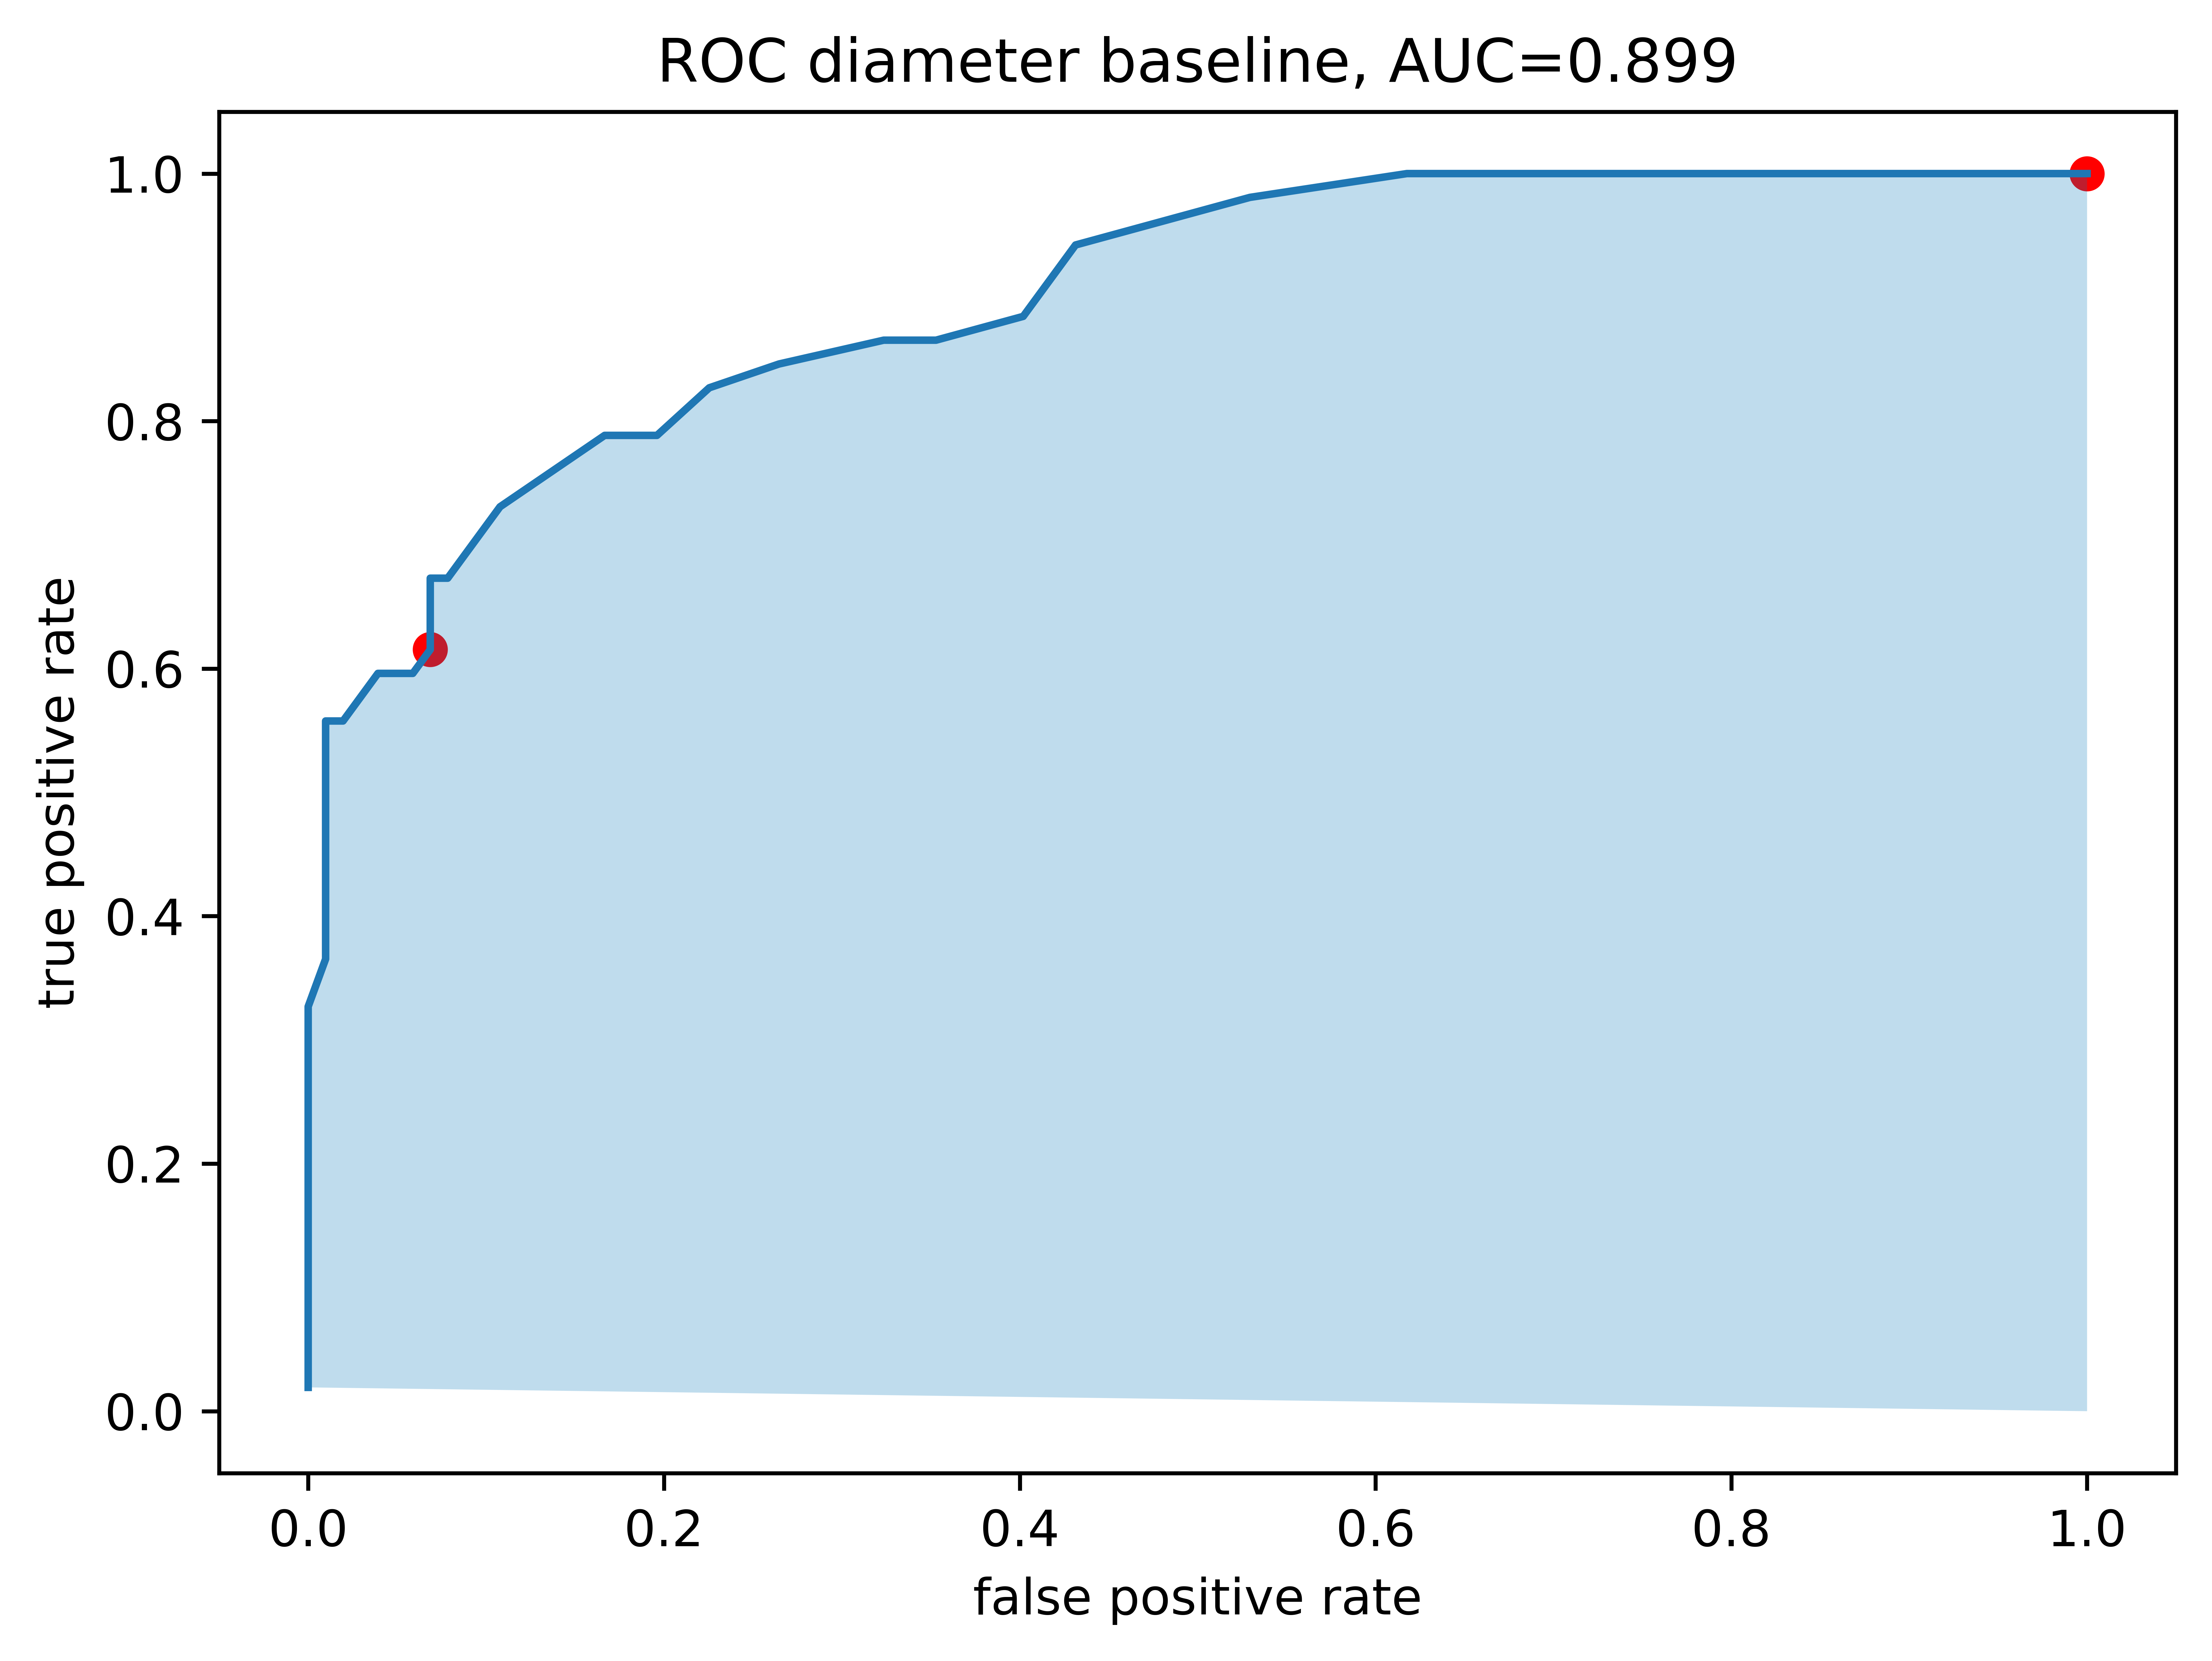

In [10]:
pyplot.figure(figsize=(7,5), dpi=1200)
for i in [62, 88]:
    pyplot.scatter(fp_diam[i], tp_diam[i], color='red')
    print(f'diam: {round(threshold[i].item(), 2)}, x: {round(fp_diam[i].item(), 2)}, y: {round(tp_diam[i].item(), 2)}')
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.title(f'ROC diameter baseline, AUC={auc_diam:.3f}')
pyplot.ylabel('true positive rate')
pyplot.xlabel('false positive rate')
pyplot.savefig('roc_diameter_baseline.png')

In [14]:
model_cls = model_classification.LunaModel()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sd = torch.load('../models/classification/cls_2022-07-22_01.39.19_malben-finetune.best.state')
model_cls.load_state_dict(sd['model_state'])
model_cls.eval();

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [10]:
ds = p2ch14.dsets.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=4)


2020-05-12 21:52:45,027 INFO     pid:7408 p2ch14.dsets:322:__init__ <p2ch14.dsets.MalignantLunaDataset object at 0x000001A65D9D96A0>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio


In [11]:
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)    
    truth += (label[:,1]>0).tolist()
    with torch.no_grad():
        _, p = model(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

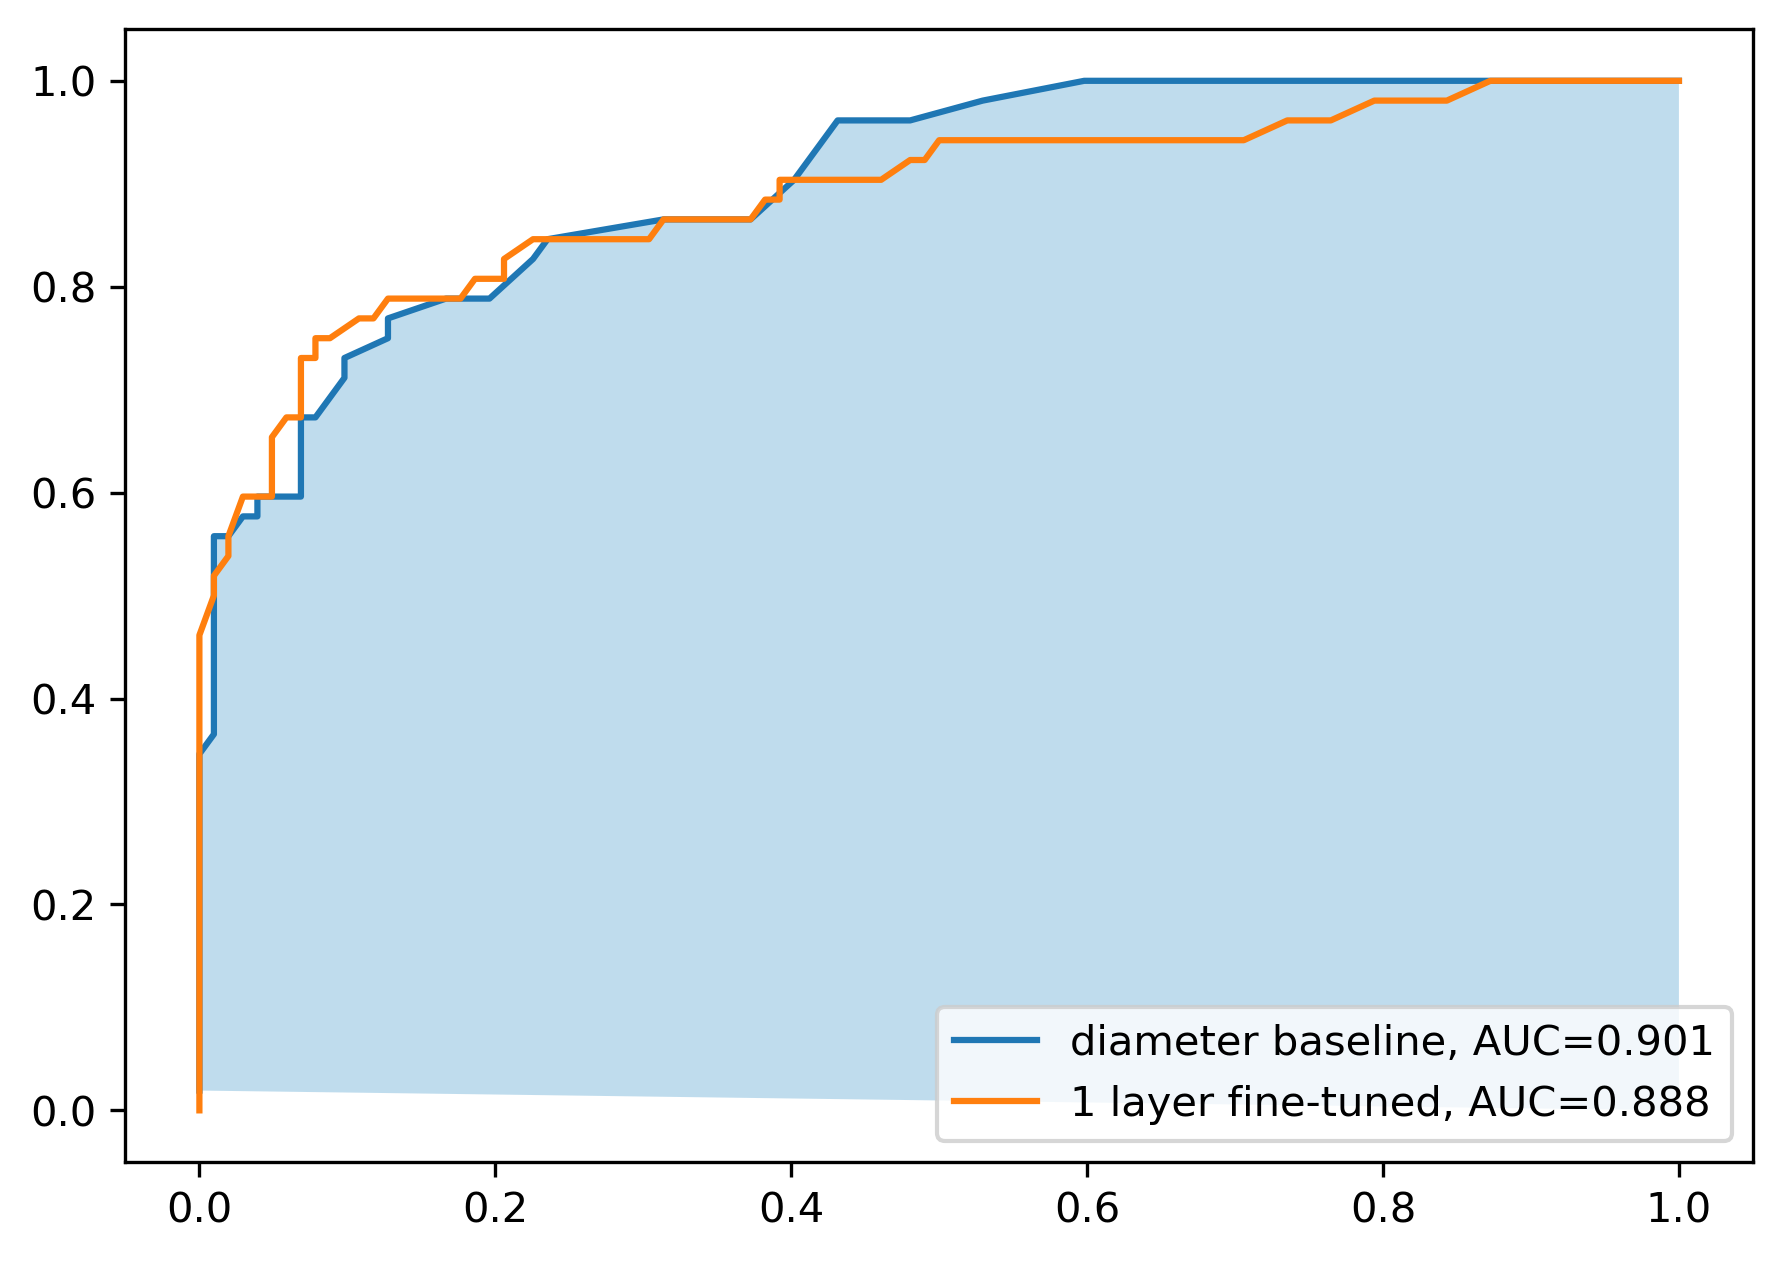

In [12]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0)
tp_finetune = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp_finetune = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben
fp_finetune_diff = fp_finetune[1:]-fp_finetune[:-1]
tp_finetune_avg  = (tp_finetune[1:]+tp_finetune[:-1])/2
auc_finetune = (fp_finetune_diff * tp_finetune_avg).sum()

pyplot.figure(figsize=(7,5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
pyplot.legend()
pyplot.savefig('roc_finetune.png')

In [13]:
if 1:
    fn = 'data/part2/models/cls_2020-02-08_00.19.45_finetune-depth2.best.state'
    model = p2ch14.model.LunaModel()
    sd = torch.load(fn, map_location='cpu')['model_state']
    model.load_state_dict(sd)
    model.to(device)
    model.eval();


In [14]:
model.eval()
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)    
    truth += (label[:,1]>0).tolist()
    with torch.no_grad():
        _, p = model(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

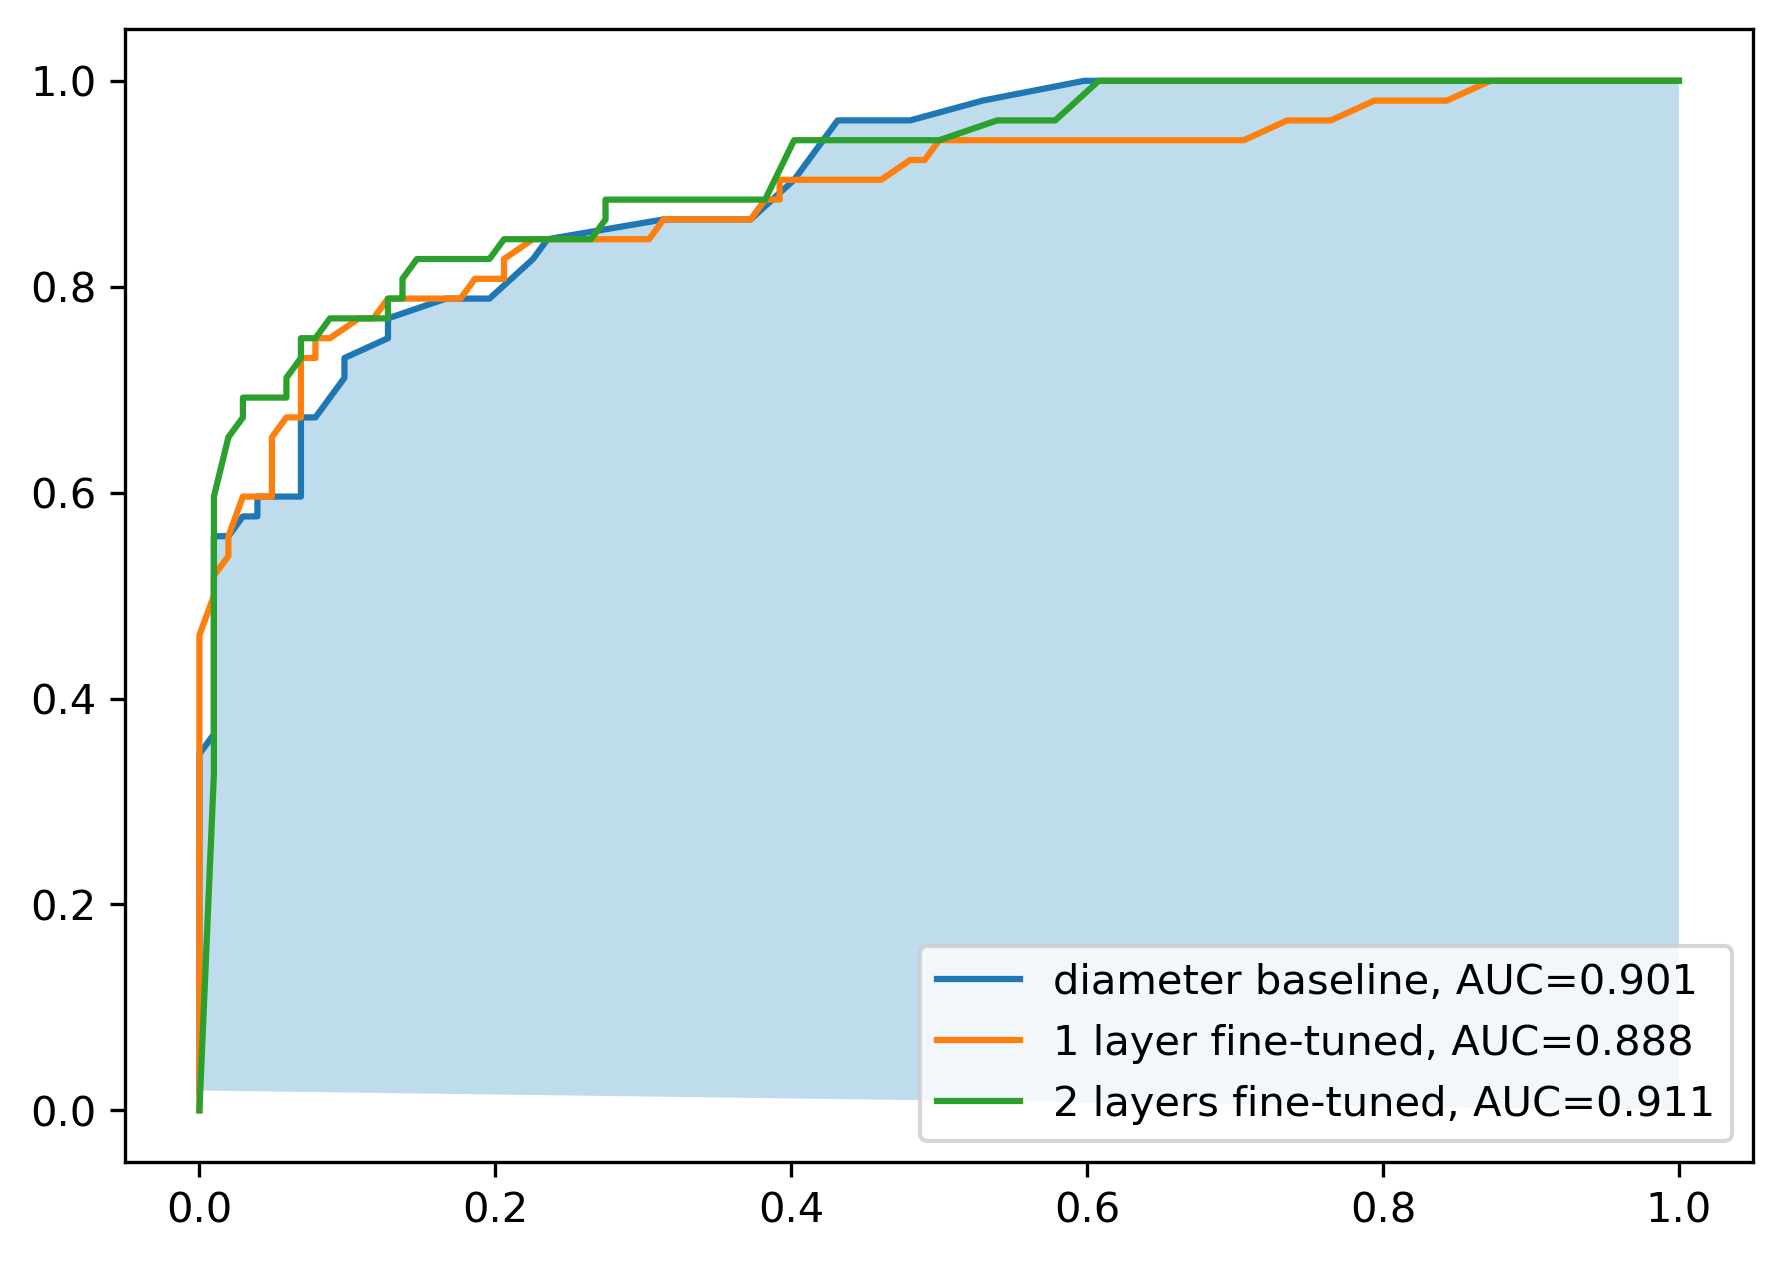

In [15]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0)
tp = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben

fp_diff = fp[1:]-fp[:-1]
tp_avg  = (tp[1:]+tp[:-1])/2
auc_modified = (fp_diff * tp_avg).sum()

pyplot.figure(figsize=(7,5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
pyplot.plot(fp, tp, label=f'2 layers fine-tuned, AUC={auc_modified:.3f}')
pyplot.legend()
pyplot.savefig('roc_modified.png')